<a href="https://colab.research.google.com/github/mengjie514/Dynamic-Social-Network-Analysis/blob/main/Descriptive_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import re
import math
import string
import requests
import json
import ast
import random
from itertools import product
from inspect import getsourcefile
from io import open

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Install fuzzywuzzy package
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Change to the target directory
os.chdir("/path/to/Colab_Notebooks/PSVI/Raw_Data_2018Midterm")

# Set the maximum column width for display
pd.set_option('display.max_colwidth', None)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load datasets from Google Drive
df_sna_filtered_2018 = pd.read_csv('/path/to/df_sna_filtered_2018.csv', encoding='utf-8', index_col=0)
df_sna_filtered_2022 = pd.read_csv('/path/to/df_sna_filtered_2022.csv', encoding='utf-8', index_col=0)

# Reset indices
df_sna_filtered_2018.reset_index(inplace=True)
df_sna_filtered_2022.reset_index(inplace=True)

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<ipython-input-5-c9d476f94761>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticks(), fontsize=12)
<ipython-input-5-c9d476f94761>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(axes[1].get_yticks(), fontsize=12)


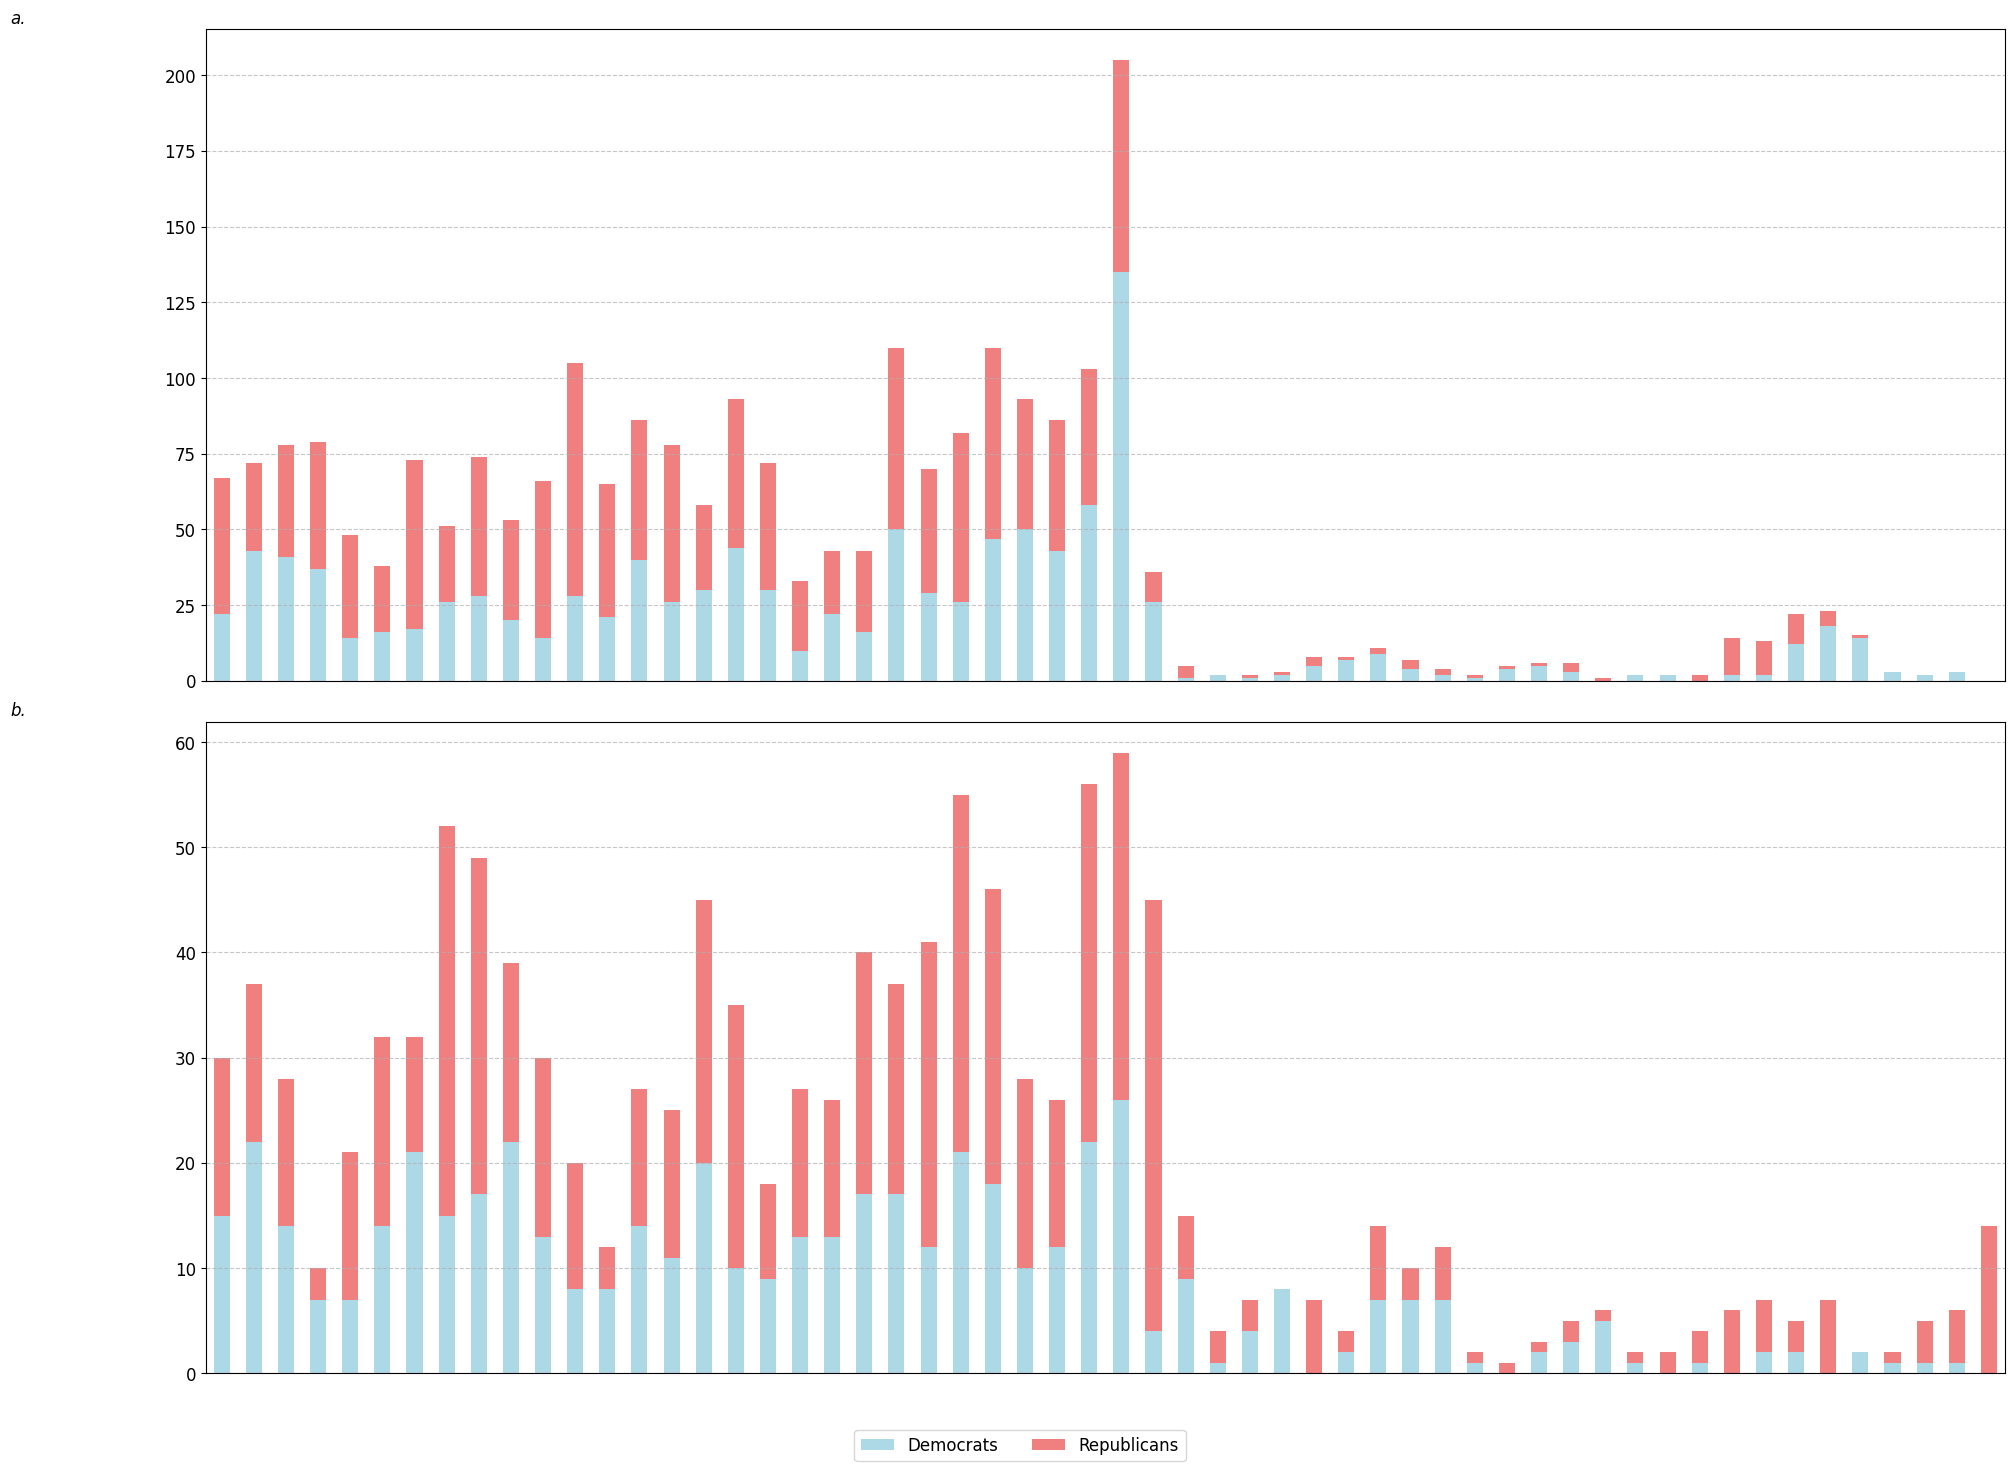

In [ ]:
# Function to format the y-tick labels as integers
def int_formatter(x, pos):
    return f'{int(x)}'

# Convert 'created_at' to datetime format correctly according to each DataFrame's date format
df_sna_filtered_2018['created_at'] = pd.to_datetime(df_sna_filtered_2018['created_at'], format='%Y-%m-%d')
df_sna_filtered_2022['created_at'] = pd.to_datetime(df_sna_filtered_2022['created_at'], format='%Y-%m-%d')  # Adjusted for ISO8601 format

# Group by date and party, and count tweets for each date
daily_tweets_2018 = df_sna_filtered_2018.groupby([df_sna_filtered_2018['created_at'].dt.date, 'screen_name_party']).size().unstack(fill_value=0)
daily_tweets_2022 = df_sna_filtered_2022.groupby([df_sna_filtered_2022['created_at'].dt.date, 'screen_name_party']).size().unstack(fill_value=0)

# Plotting the data
fig, axes = plt.subplots(2, 1, figsize=(20, 14), sharex=True)

# Party colors
party_colors = {'D': 'lightblue', 'R': 'lightcoral'}

# Plotting the data for 2018
daily_tweets_2018.plot(kind='bar', stacked=True, color=[party_colors.get(x, '#333333') for x in daily_tweets_2018.columns], ax=axes[0])
axes[0].set_title('', fontsize=12)
axes[0].set_ylabel('')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].xaxis.set_visible(False)  # Hides the x-axis
axes[0].get_legend().remove()
axes[0].set_yticklabels(axes[0].get_yticks(), fontsize=12)
axes[0].text(-0.1, 1.03, 'a.', transform=axes[0].transAxes, fontsize=12, fontstyle='italic', va='top', ha='right')
axes[0].yaxis.set_major_formatter(FuncFormatter(int_formatter))

# Plotting the data for 2022
daily_tweets_2022.plot(kind='bar', stacked=True, color=[party_colors.get(x, '#333333') for x in daily_tweets_2022.columns], ax=axes[1])
axes[1].set_title('', fontsize=12)
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].xaxis.set_visible(False)  # Hides the x-axis
axes[1].get_legend().remove()
axes[1].set_yticklabels(axes[1].get_yticks(), fontsize=12)
axes[1].text(-0.1, 1.03, 'b.', transform=axes[1].transAxes, fontsize=12, fontstyle='italic', va='top', ha='right')
axes[1].yaxis.set_major_formatter(FuncFormatter(int_formatter))

# Create a custom legend with fontsize set
custom_legend = [Patch(facecolor='lightblue', label='Democrats'),
                 Patch(facecolor='lightcoral', label='Republicans')]
fig.legend(handles=custom_legend, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)

# Add title below the graph
fig.text(0.5, -0.1, '', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

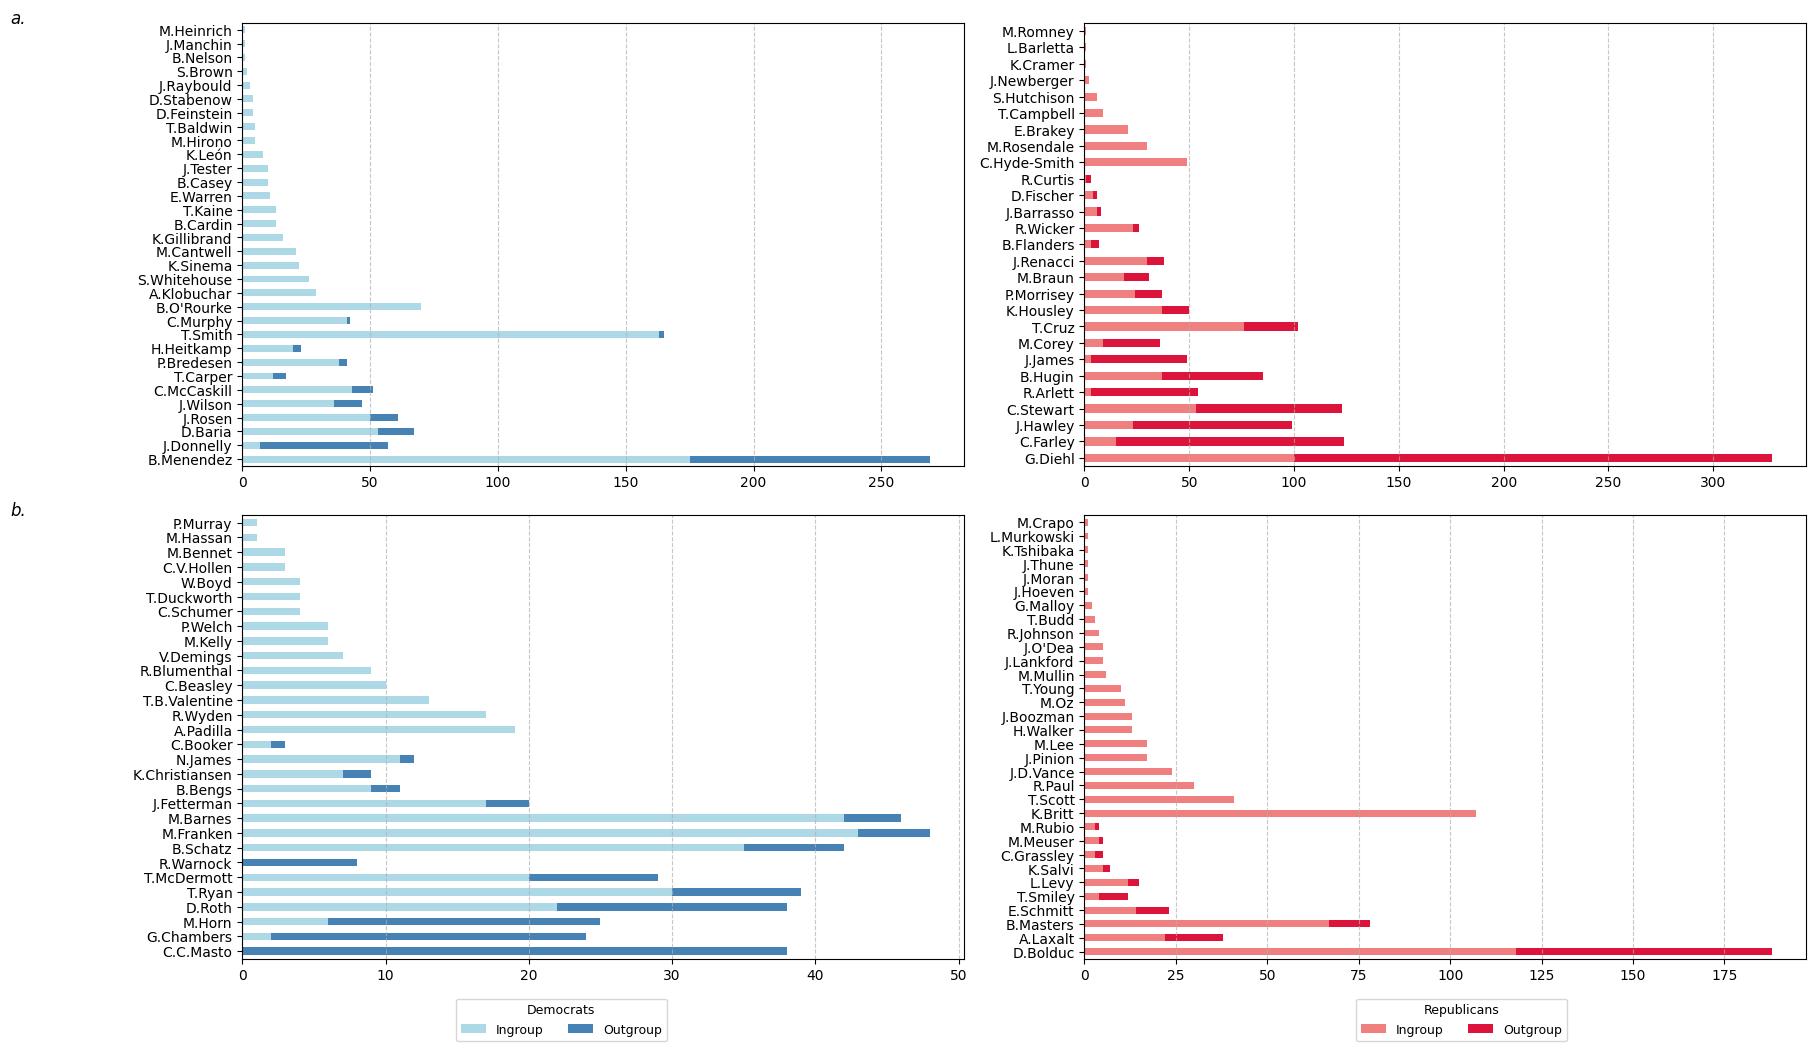

In [ ]:
# Create a new column 'Group' based on screen_name_party and connected_screen_name_party
df_sna_filtered_2018['Group'] = df_sna_filtered_2018.apply(lambda row: 'Ingroup' if row['screen_name_party'] == row['connected_screen_name_party'] else 'Outgroup', axis=1)
df_sna_filtered_2022['Group'] = df_sna_filtered_2022.apply(lambda row: 'Ingroup' if row['screen_name_party'] == row['connected_screen_name_party'] else 'Outgroup', axis=1)

# Prepare data for Fig. 1a
grouped_data_party_2018 = df_sna_filtered_2018.groupby(['screen_name', 'screen_name_party', 'Group']).size().unstack().fillna(0).reset_index()
group_d_2018 = grouped_data_party_2018[grouped_data_party_2018['screen_name_party'] == 'D'].sort_values(by=['Outgroup', 'Ingroup'], ascending=[False, False])
group_r_2018 = grouped_data_party_2018[grouped_data_party_2018['screen_name_party'] == 'R'].sort_values(by=['Outgroup', 'Ingroup'], ascending=[False, False])

# Prepare data for Fig. 1b
grouped_data_party_2022 = df_sna_filtered_2022.groupby(['screen_name', 'screen_name_party', 'Group']).size().unstack().fillna(0).reset_index()
group_d_2022 = grouped_data_party_2022[grouped_data_party_2022['screen_name_party'] == 'D'].sort_values(by=['Outgroup', 'Ingroup'], ascending=[False, False])
group_r_2022 = grouped_data_party_2022[grouped_data_party_2022['screen_name_party'] == 'R'].sort_values(by=['Outgroup', 'Ingroup'], ascending=[False, False])

# Figure setup
fig = plt.figure(figsize=(18, 10))  # Adjusted overall figure size
gs = fig.add_gridspec(2, 2)  # Adjusted grid configuration for 4 rows, 1 column

# Define colors and hatching patterns
party_colors = {'D': 'lightblue', 'R': 'lightcoral'}
ingroup_outgroup_colors_D = {'Ingroup': 'lightblue', 'Outgroup': 'steelblue'}
ingroup_outgroup_colors_R = {'Ingroup': 'lightcoral', 'Outgroup': '#DC143C'}

# Fig. 2a: Overall Tweets by Democratic and Republican Candidates in 2018
# Democratic Candidates
ax0a = fig.add_subplot(gs[0, 0])  # Spanning the entire row for Democratic candidates
democrat_data = group_d_2018.set_index('screen_name')[['Ingroup', 'Outgroup']]
democrat_data['Ingroup'].plot(kind='barh', color=ingroup_outgroup_colors_D['Ingroup'], ax=ax0a, label='Ingroup')
democrat_data['Outgroup'].plot(kind='barh', color=ingroup_outgroup_colors_D['Outgroup'], ax=ax0a, label='Outgroup', left=democrat_data['Ingroup'])
ax0a.set_title('', fontsize=10)
ax0a.set_xlabel('', fontsize=10)
ax0a.set_ylabel('', fontsize=10)
ax0a.tick_params(axis='y', labelsize=10)
ax0a.text(-0.3, 1.03, 'a.', transform=ax0a.transAxes, fontsize=12, fontstyle='italic', va='top', ha='right')
ax0a.grid(axis='x', linestyle='--', alpha=0.7)

# Republican Candidates
ax0b = fig.add_subplot(gs[0, 1])  # Spanning the entire row for Republican candidates
republican_data = group_r_2018.set_index('screen_name')[['Ingroup', 'Outgroup']]
republican_data['Ingroup'].plot(kind='barh', color=ingroup_outgroup_colors_R['Ingroup'], ax=ax0b, label='Ingroup')
republican_data['Outgroup'].plot(kind='barh', color=ingroup_outgroup_colors_R['Outgroup'], ax=ax0b, label='Outgroup', left=republican_data['Ingroup'])
ax0b.set_title('', fontsize=10)
ax0b.set_xlabel('', fontsize=10)
ax0b.set_ylabel('', fontsize=10)
ax0b.tick_params(axis='y', labelsize=10)
ax0b.grid(axis='x', linestyle='--', alpha=0.7)

# Fig. 2b: Overall Tweets by Democratic and Republican Candidates in 2022
# Democratic Candidates
ax1a = fig.add_subplot(gs[1, 0])  # Spanning the entire row for Democratic candidates
democrat_data = group_d_2022.set_index('screen_name')[['Ingroup', 'Outgroup']]
democrat_data['Ingroup'].plot(kind='barh', color=ingroup_outgroup_colors_D['Ingroup'], ax=ax1a, label='Ingroup')
democrat_data['Outgroup'].plot(kind='barh', color=ingroup_outgroup_colors_D['Outgroup'], ax=ax1a, label='Outgroup', left=democrat_data['Ingroup'])
ax1a.set_title('', fontsize=10)
ax1a.set_xlabel('', fontsize=10)
ax1a.set_ylabel('', fontsize=10)
ax1a.tick_params(axis='y', labelsize=10)
ax1a.text(-0.3, 1.03, 'b.', transform=ax1a.transAxes, fontsize=12, fontstyle='italic', va='top', ha='right')
ax1a.grid(axis='x', linestyle='--', alpha=0.7)

# Republican Candidates
ax1b = fig.add_subplot(gs[1, 1])  # Spanning the entire row for Republican candidates
republican_data = group_r_2022.set_index('screen_name')[['Ingroup', 'Outgroup']]
republican_data['Ingroup'].plot(kind='barh', color=ingroup_outgroup_colors_R['Ingroup'], ax=ax1b, label='Ingroup')
republican_data['Outgroup'].plot(kind='barh', color=ingroup_outgroup_colors_R['Outgroup'], ax=ax1b, label='Outgroup', left=republican_data['Ingroup'])
ax1b.set_title('', fontsize=10)
ax1b.set_xlabel('', fontsize=10)
ax1b.set_ylabel('', fontsize=10)
ax1b.tick_params(axis='y', labelsize=10)
ax1b.grid(axis='x', linestyle='--', alpha=0.7)

# Get handles and labels for the Democratic candidates plot
handles_d, labels_d = ax0a.get_legend_handles_labels()
dem_legend = fig.legend(handles=handles_d, labels=labels_d, loc='lower center',
                        bbox_to_anchor=(0.3, -0.05), ncol=2, fontsize=9, title='Democrats')
dem_legend.get_title().set_fontsize('9')  # Set the title font size

# Get handles and labels for the Republican candidates plot
handles_r, labels_r = ax1b.get_legend_handles_labels()
rep_legend = fig.legend(handles=handles_r, labels=labels_r, loc='lower center',
                        bbox_to_anchor=(0.8, -0.05), ncol=2, fontsize=9, title='Republicans')
rep_legend.get_title().set_fontsize('9')  # Set the title font size

# Add title below the graph
fig.text(0.5, -0.1, '', ha='center', fontsize=12, fontweight='bold')

# Adjust the layout
plt.tight_layout()
plt.show()